## Plant Feature Classification
This project will look at identifying, and scoring, plant images based images of them. We'll use data from the related Kaggle contest

In [ ]:
# setup
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# # download data
! kaggle competitions download -c planttraits2024
! unzip -qq planttraits2024.zip

... resuming from 1274019840 bytes (2480352632 bytes left) ...
100% 3.50G/3.50G [02:04<00:00, 22.3MB/s]
100% 3.50G/3.50G [02:04<00:00, 19.8MB/s]


In [ ]:
!pip install --upgrade keras-cv tensorflow
!pip install --upgrade keras

In [ ]:
import os
import random
import pandas as pd
import matplotlib.image as mpimg

from os.path import join
import numpy as np
import pandas as pd
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
import keras_cv

In [ ]:
import os, shutil, pathlib

class Config:
    sub = "sample_submission.csv"
    trgts = "target_name_meta.tsv"
    train_path = "train.csv"
    test_path = "test.csv"
    train_image_path = "train_images/"
    test_image_path = "test_images/"
    seed = 42
    fold = 0 # which fold to set as validation data
    image_size = [224, 224]
    batch_size = 96
    epochs = 10
    num_classes = 6
    num_folds = 5
    class_names = ['X4_mean', 'X11_mean', 'X18_mean',
                   'X26_mean', 'X50_mean', 'X3112_mean',]
    aux_class_names = list(map(lambda x: x.replace("mean","sd"), class_names))
    aux_num_classes = len(aux_class_names)
    preset = "efficientnetv2_b2_imagenet"  # Name of pretrained classifier
    lr_mode = "step" # LR scheduler mode from one of "cos", "step", "exp"
    verbose = 1

config = Config()

Let's set a constant seed value for reproducable results

In [ ]:
keras.utils.set_random_seed(config.seed)

Let's take a quick look at what training data looks like

In [ ]:
# training and validation data set
df = pd.read_csv(config.train_path)
df['image_path'] = './train_images/'+df['id'].astype(str)+'.jpeg'
df.loc[:, config.aux_class_names] = df.loc[:, config.aux_class_names].fillna(-1)
display(df.head(2))

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd,image_path
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,1.243779,1.849375,50.216034,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054,./train_images/192027691.jpeg
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,0.642940,1.353468,574.098472,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477,./train_images/195542235.jpeg


In [ ]:
#test data
test_df = pd.read_csv('test.csv')
test_df['image_path'] = 'test_images/'+test_df['id'].astype(str)+'.jpeg'
FEATURE_COLS = test_df.columns[1:-1].tolist()
display(test_df.head(2))

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,VOD_X_1997_2018_multiyear_mean_m04,VOD_X_1997_2018_multiyear_mean_m05,VOD_X_1997_2018_multiyear_mean_m06,VOD_X_1997_2018_multiyear_mean_m07,VOD_X_1997_2018_multiyear_mean_m08,VOD_X_1997_2018_multiyear_mean_m09,VOD_X_1997_2018_multiyear_mean_m10,VOD_X_1997_2018_multiyear_mean_m11,VOD_X_1997_2018_multiyear_mean_m12,image_path
0,195066138,10.55810,961.500000,31.586735,13.728325,648.038208,25.351532,127,152,137,...,0.469694,0.455849,0.528211,0.555653,0.549882,0.542905,0.517507,0.462724,0.427107,test_images/195066138.jpeg
1,195524180,7.00287,1120.025513,23.000000,7.258863,973.889404,39.135712,106,167,127,...,0.428838,0.456266,0.470074,0.468038,0.475943,0.483206,0.477197,0.432732,0.423728,test_images/195524180.jpeg


So, we've attatched the image paths respective to each row of traits. Let's define methods for data pre-processing and data augmentation. We'll build these as general functions that will be applicable for both training data, validation data, and test data.

In [ ]:
# responsible for data augmentation -> let this be default behaviour
def build_augmenter():
    # Define augmentations -> applied to each image after one forward pass
    aug_layers = [
        keras_cv.layers.RandomBrightness(factor=0.1, value_range=(0, 1)),
        keras_cv.layers.RandomContrast(factor=0.1, value_range=(0, 1)),
        keras_cv.layers.RandomSaturation(factor=(0.45, 0.55)),
        keras_cv.layers.RandomHue(factor=0.1, value_range=(0, 1)),
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.15), width_factor=(0.06, 0.15)),
        keras_cv.layers.RandomFlip(mode="horizontal_and_vertical"),
        keras_cv.layers.RandomZoom(height_factor=(0.05, 0.15)),
        keras_cv.layers.RandomRotation(factor=(0.01, 0.05)),
    ]

    # Apply augmentations to random samples
    aug_layers = [keras_cv.layers.RandomApply(x, rate=0.5) for x in aug_layers]

    # Build augmentation layer
    augmenter = keras_cv.layers.Augmenter(aug_layers)

    # Apply augmentations
    def augment(input, label):
        images = input["images"]
        aug_data = {"images": images}
        aug_data = augmenter(aug_data)
        input["images"] = aug_data["images"]
        return input, label
    return augment

# resonsible for converting images into arrays
def build_decoder(with_labels=True, target_size=config.image_size):
    def decode_image(input):
        path = input["images"]

        # Read jpeg image
        file_bytes = tf.io.read_file(path)
        image = tf.io.decode_jpeg(file_bytes)

        # Resize
        image = tf.image.resize(image, size=target_size, method="area")

        # Rescale image
        image = tf.cast(image, tf.float32)
        image /= 255.0

        # Reshape
        image = tf.reshape(image, [*target_size, 3])

        input["images"] = image
        return input

    def decode_label(label, num_classes):
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [num_classes])
        return label

    def decode_with_labels(input, labels=None):
        input = decode_image(input)
        label = decode_label(labels[0], config.num_classes)
        aux_label = decode_label(labels[1], config.aux_num_classes)
        return (input, (label, aux_label))

    return decode_with_labels if with_labels else decode_image


def build_dataset(
    paths,
    features,
    labels=None,
    aux_labels=None,
    batch_size=32,
    cache=True,
    decode_fn=None,
    augment_fn=None,
    augment=False,
    repeat=True,
    shuffle=1024,
    cache_dir="",
    drop_remainder=False,
):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None or aux_labels is not None)

    if augment_fn is None:
        augment_fn = build_augmenter()

    AUTO = tf.data.experimental.AUTOTUNE

    input = {"images": paths, "features": features}
    slices = (input, (labels, aux_labels)) if labels is not None else inp


    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle:
        ds = ds.shuffle(shuffle, seed=config.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

We need to split our training data. Its important to ensure we have stratified folds (stratified means that the proportion of classes in each fold remains similar to the overall proportion of classes in the entire dataset).

In [ ]:
from sklearn.model_selection import StratifiedKFold

# create this object to split the dataset later
skf = StratifiedKFold(n_splits=config.num_folds, shuffle=True, random_state=42)

# Create separate bin for each traits
for i, trait in enumerate(config.class_names):

    # Determine the bin edges dynamically based on the distribution of traits
    bin_edges = np.percentile(df[trait], np.linspace(0, 100, config.num_folds + 1))
    df[f"bin_{i}"] = np.digitize(df[trait], bin_edges)

# Concatenate the bins into a final bin
df["final_bin"] = (
    df[[f"bin_{i}" for i in range(len(config.class_names))]]
    .astype(str)
    .agg("".join, axis=1)
)

# Perform the stratified split using final bin
df = df.reset_index(drop=True)
for fold, (train_idx, valid_idx) in enumerate(skf.split(df, df["final_bin"])):
    df.loc[valid_idx, "fold"] = fold

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
display(df['X4_mean'])

0        0.401753
1        0.480334
2        0.796917
3        0.525236
4        0.411821
           ...   
55484    0.337243
55485    0.424371
55486    0.639659
55487    0.774642
55488    0.551888
Name: X4_mean, Length: 55489, dtype: float64

In [ ]:
display(df.head()['X4_mean'])

0    0.401753
1    0.480334
2    0.796917
3    0.525236
4    0.411821
Name: X4_mean, dtype: float64

In [ ]:
display(df.head(5))

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X3112_sd,image_path,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,final_bin,fold
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,15.045054,./train_images/192027691.jpeg,2,2,1,2,4,1,221241,2.0
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,11.004477,./train_images/195542235.jpeg,3,3,2,2,2,3,332223,1.0
2,196639184,14.254504,902.071411,49.642857,17.873655,387.977753,22.807142,107,133,119,...,-1.000000,./train_images/196639184.jpeg,5,1,5,2,5,3,515253,0.0
3,195728812,18.680834,1473.933350,163.100006,45.009758,381.053986,20.436666,120,131,125,...,141.857187,./train_images/195728812.jpeg,3,2,3,1,2,3,323123,4.0
4,195251545,0.673204,530.088867,50.857777,38.230709,1323.526855,45.891998,91,146,120,...,87.146899,./train_images/195251545.jpeg,2,3,3,4,5,4,233454,2.0


A quick note on `bin_edges = np.percentile(df[trait], np.linspace(0, 100, CFG.num_folds + 1))`. What this is doing is:
- First, we are creating percentile buckets from 0 to 100. So, if we had 5 buckets, these would be `20%`, `40%`, `60%`, `80%`, and `100%`.
- For each of the column data we are interested in (`X4_mean` for example), we create new columns for each new "bucket group" -- 6, one for each target
- In each row, we've placed it into one bucket for each target group

Now that we've split the data, we build our train and validation datasets.  

In [ ]:
from sklearn.preprocessing import StandardScaler

# Sample from full data
sample_df = df.copy()
train_df = sample_df[sample_df.fold != config.fold]
valid_df = sample_df[sample_df.fold == config.fold]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Normalize features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_df[FEATURE_COLS].values)
valid_features = scaler.transform(valid_df[FEATURE_COLS].values)

# Train
train_paths = train_df.image_path.values

train_labels = train_df[config.class_names].values
train_aux_labels = train_df[config.aux_class_names].values
train_ds = build_dataset(train_paths, train_features, train_labels, train_aux_labels,
                         batch_size=config.batch_size,
                         repeat=True, shuffle=True, augment=True, cache=False)

# Valid
valid_paths = valid_df.image_path.values
valid_labels = valid_df[config.class_names].values
valid_aux_labels = valid_df[config.aux_class_names].values
valid_ds = build_dataset(valid_paths, valid_features, valid_labels, valid_aux_labels,
                         batch_size=config.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=False)

# Num Train: 44391 | Num Valid: 11098


Quick note for the above:
- `train_df[FEATURE_COLS]` is selecting a column from the dataframe. This returns a dataframe with only that column
- `train_df[FEATURE_COLS.values]`: Here, `FEATURE_COLS.values` returns the underlying numpy array of the `FEATURE_COLS` dataframe
Since we're scaling these, we need the numpy array

Let's quickly take a look at our data more closely:

In [ ]:
inps, tars = next(iter(train_ds))
imgs = inps["images"]
num_imgs, num_cols = 8, 4

plt.figure(figsize=(4 * num_cols, num_imgs // num_cols * 5))
for i, (img, tar) in enumerate(zip(imgs[:num_imgs], tars[0][:num_imgs])):
    plt.subplot(num_imgs // num_cols, num_cols, i + 1)
    img = img.numpy()
    tar = tar.numpy()

    img = (img - img.min()) / (img.max() + 1e-4)

    formatted_tar = "\n".join(
        [
            ", ".join(
                f"{name.replace('_mean','')}: {val:.2f}"
                for name, val in zip(config.class_names[j : j + 3], tar[j : j + 3])
            )
            for j in range(0, len(config.class_names), 3)
        ]
    )

    plt.imshow(img)
    plt.title(f"[{formatted_tar}]")
    plt.axis("off")

plt.tight_layout()
plt.show()

Now, let's define our model. This will be unlike the CNNs you have buit before. This model is multi-modal. That is, it takes in image data in addition to tabular data. Here is the model defined from Keras' notebook in Kaggle. Let's try it out.

We define our own loss function:

In [ ]:
from keras import ops

class R2Loss(keras.losses.Loss):
    def __init__(self, use_mask=False, name="r2_loss"):
        super().__init__(name=name)
        self.use_mask = use_mask

    def call(self, y_true, y_pred):
        if self.use_mask:
            mask = (y_true != -1)
            y_true = ops.where(mask, y_true, 0.0)
            y_pred = ops.where(mask, y_pred, 0.0)
        SS_res = ops.sum(ops.square(y_true - y_pred), axis=0)  # (B, C) -> (C,)
        SS_tot = ops.sum(ops.square(y_true - ops.mean(y_true, axis=0)), axis=0)  # (B, C) -> (C,)
        r2_loss = SS_res / (SS_tot + 1e-6)  # (C,)
        return ops.mean(r2_loss)  # ()

class R2Metric(keras.metrics.Metric):
    def __init__(self, name="r2", **kwargs):
        super(R2Metric, self).__init__(name=name, **kwargs)
        self.SS_res = self.add_weight(name='SS_res', shape=(6,), initializer='zeros')
        self.SS_tot = self.add_weight(name='SS_tot', shape=(6,) ,initializer='zeros')
        self.num_samples = self.add_weight(name='num_samples', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        SS_res = ops.sum(ops.square(y_true - y_pred), axis=0)
        SS_tot = ops.sum(ops.square(y_true - ops.mean(y_true, axis=0)), axis=0)
        self.SS_res.assign_add(SS_res)
        self.SS_tot.assign_add(SS_tot)
        self.num_samples.assign_add(ops.cast(ops.shape(y_true)[0], "float32"))

    def result(self):
        r2 = 1 - self.SS_res / (self.SS_tot + 1e-6)
        return ops.mean(r2)

    def reset_states(self):
        self.total_SS_res.assign(0)
        self.total_SS_tot.assign(0)
        self.num_samples.assign(0)

In this version, we need to make a couple of changes. First of all, in the past implementation, we, we were just using the `EfficientNetV2`, while also changings its parameters during training. Let's try not actually training it, and only passing the images through it, then passing that outout through our own model and only training our new layers instead of the base -> we'll freeze training for this.

In [ ]:
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(config.preset)
backbone.summary()

100%|██████████| 1.79k/1.79k [00:00<00:00, 1.82MB/s]
100%|██████████| 34.2M/34.2M [00:03<00:00, 10.0MB/s]


Model: "efficient_net_v2b2_backbone"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ stem_conv (Conv2D)                   │ (None, None, None, 32)      │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ stem_bn (BatchNormalization)         │ (None, None, None, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ stem_activation (Activation)         │ (None, None, None, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1a_ (FusedMBConvBlock)          │ (None, None, None, 16)      │           4,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1b_ (FusedMBConvBlock)          │ (None, None, None, 16)      │           2,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2a_ (FusedMBConvBlock)          │ (None, None, None, 32)      │          11,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2b_ (FusedMBConvBlock)          │ (None, None, None, 32)      │          41,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2c_ (FusedMBConvBlock)          │ (None, None, None, 32)      │          41,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3a_ (FusedMBConvBlock)          │ (None, None, None, 56)      │          44,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3b_ (FusedMBConvBlock)          │ (None, None, None, 56)      │         126,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3c_ (FusedMBConvBlock)          │ (None, None, None, 56)      │         126,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4a_ (MBConvBlock)               │ (None, None, None, 104)     │          46,574 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4b_ (MBConvBlock)               │ (None, None, None, 104)     │         116,090 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4c_ (MBConvBlock)               │ (None, None, None, 104)     │         116,090 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4d_ (MBConvBlock)               │ (None, None, None, 104)     │         116,090 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5a_ (MBConvBlock)               │ (None, None, None, 120)     │         183,962 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5b_ (MBConvBlock)               │ (None, None, None, 120)     │         229,470 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5c_ (MBConvBlock)               │ (None, None, None, 120)     │         229,470 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5d_ (MBConvBlock)               │ (None, None, None, 120)     │         229,470 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 8,687,086 (33.14 MB)

 Non-trainable params: 82,288 (321.44 KB)

In [ ]:
# Define input layers
img_input = keras.Input(shape=(*config.image_size, 3), name="images")
feat_input = keras.Input(shape=(len(FEATURE_COLS),), name="features")

# Branch for image input
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(config.preset)
# Freeze the backbone layers
for layer in backbone.layers:
    layer.trainable = False

x1 = backbone(img_input)
x1 = keras.layers.BatchNormalization()(x1)
x1 = keras.layers.SeparableConv2D(filters=1408, kernel_size=3, padding="same", use_bias=False)(x1)
x1 = keras.layers.BatchNormalization()(x1)
x1 = keras.layers.Activation("relu")(x1)
x1 = keras.layers.SeparableConv2D(filters=1408, kernel_size=3, padding="same", use_bias=False)(x1)
x1 = keras.layers.GlobalAveragePooling2D()(x1)
x1 = keras.layers.Dropout(0.2)(x1)

# Branch for tabular/feature input
x2 = keras.layers.Dense(326, activation="selu")(feat_input)
x2 = keras.layers.Dense(256, activation="selu")(x2)
x2 = keras.layers.Dense(128, activation="selu")(x2)
x2 = keras.layers.Dense(64, activation="selu")(x2)
x2 = keras.layers.Dropout(0.1)(x2)

# Concatenate both branches
concat = keras.layers.Concatenate()([x1, x2])

# Output layer
out1 = keras.layers.Dense(config.num_classes, activation=None, name="head")(concat)
out2 = keras.layers.Dense(config.aux_num_classes, activation="relu", name="aux_head")(concat)
out = {"head": out1, "aux_head":out2}

In [ ]:
# Build model
model = keras.models.Model([img_input, feat_input], out, name="PlantTraits2024")

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss={
        "head": R2Loss(use_mask=False),
        "aux_head": R2Loss(use_mask=True), # use_mask to ignore `NaN` auxiliary labels
    },
    loss_weights={"head": 1.0, "aux_head": 0.3},  # more weight to main task
    metrics={"head": R2Metric()}, # evaluation metric only on main task
)

model.summary()

Model: "PlantTraits2024"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer)       │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficient_net_v2b2_backb… │ (None, 7, 7, 1408)     │      8,769,374 │ images[0][0]           │
│ (EfficientNetV2Backbone)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 7, 7, 1408)     │          5,632 │ efficient_net_v2b2_ba… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 7, 7, 1408)     │      1,995,136 │ batch_normalization[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ features (InputLayer)     │ (None, 163)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 7, 7, 1408)     │          5,632 │ separable_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 326)            │         53,464 │ features[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 7, 7, 1408)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         83,712 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 7, 7, 1408)     │      1,995,136 │ activation[0][0]       │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         32,896 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 1408)           │              0 │ separable_conv2d_1[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 64)             │          8,256 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1408)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1472)           │              0 │ dropout[0][0],         │
│                           │                        │                │ dropout_1[0][0]        │
├──────────────────────

 Total params: 12,966,914 (49.46 MB)

 Trainable params: 4,191,908 (15.99 MB)

 Non-trainable params: 8,775,006 (33.47 MB)

Something new we will take a look at, is this idea of adjusting the learning rate as we progress through training. This helps ensure we have optimal convergence, and that we are not stuck in local minima.

In [ ]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 8e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

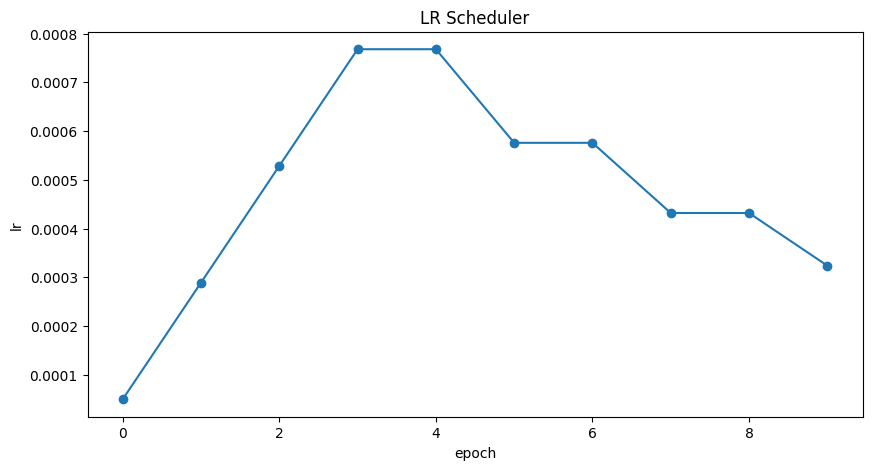

In [ ]:
lr_cb = get_lr_callback(config.batch_size, mode=config.lr_mode, plot=True)

Let's have a model checkpoint, to save our best performing epoch each time

In [ ]:
ckpt_cb = keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    monitor="val_head_r2",
    save_best_only=True,
    save_weights_only=False,
    mode="max",
)

Now we train the model:

In [ ]:
history = model.fit(
    train_ds,
    epochs=config.epochs,
    callbacks=[lr_cb, ckpt_cb],
    steps_per_epoch=len(train_df) // config.batch_size,
    validation_data=valid_ds,
    verbose=config.verbose,
)

Epoch 1/10
 54/462 ━━━━━━━━━━━━━━━━━━━━ 12:54 2s/step - head_r2: -0.1445 - loss: 2.0609

KeyboardInterrupt: 